In [1]:
#Imports necessários

from astroNN.datasets import load_galaxy10
from astroNN.datasets.galaxy10 import galaxy10cls_lookup

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, SeparableConv2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, Normalization, RandomFlip, RandomRotation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs', update_freq='epoch', histogram_freq=1)

np.set_printoptions(precision=4, suppress=True)

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    # Removed the name argument as it's not supported in tf.image.rot90
    image = tf.image.rot90(image, k=1)
    return image, label


WARNING! APOGEE environment variable SDSS_LOCAL_SAS_MIRROR not set
WARNING! Gaia environment variable GAIA_TOOLS_DATA not set


In [2]:
#Load das imagens

images, labels = load_galaxy10()
labels = utils.to_categorical(labels, 10)

C:\Users\User\.astroNN\datasets\Galaxy10.h5 was found!


In [3]:
images = images / 255.0


In [4]:
training_dataX, test_dataX, training_labelsy, test_labelsy = train_test_split(images, labels, test_size=0.3, random_state=21)

training_data = tf.data.Dataset.from_tensor_slices((training_dataX, training_labelsy))
test_data = tf.data.Dataset.from_tensor_slices((test_dataX, test_labelsy))

buffer_size = 5000
training_data = training_data.shuffle(buffer_size)


training_data = training_data.map(augment)
training_data = training_data.batch(32)
training_data = training_data.prefetch(tf.data.experimental.AUTOTUNE)

test_data = test_data.batch(64)
test_data = test_data.prefetch()



In [5]:
model = Sequential([
    
    
    
    SeparableConv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    
    SeparableConv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    SeparableConv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    SeparableConv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    GlobalAveragePooling2D(),
    
    Dense(1024, activation='relu'),
    Dropout(0.2),
    
    Dense(512, activation='relu'),
    
    Dense(128, activation='relu'),
    
    Dense(10, activation='softmax')
    
  
    

])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d (SeparableC (None, 256, 256, 32)      155       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 256, 256, 64)      2400      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 128, 128, 128)     8896      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 128)     5

In [6]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [7]:
history = model.fit(
    
    x=training_data,
    validation_data=test_data,
    epochs=20,
    callbacks=[tensorboard_callback],

)


Epoch 1/20
239/239 [==============================] - 26s 92ms/step - loss: 1.2780 - accuracy: 0.4811 - val_loss: 1.8343 - val_accuracy: 0.3095
Epoch 2/20
239/239 [==============================] - 21s 89ms/step - loss: 0.9957 - accuracy: 0.5835 - val_loss: 1.2310 - val_accuracy: 0.5089
Epoch 3/20
239/239 [==============================] - 21s 89ms/step - loss: 0.7961 - accuracy: 0.6884 - val_loss: 0.9657 - val_accuracy: 0.6180
Epoch 4/20
239/239 [==============================] - 21s 90ms/step - loss: 0.6838 - accuracy: 0.7420 - val_loss: 0.7197 - val_accuracy: 0.7283
Epoch 5/20
239/239 [==============================] - 22s 90ms/step - loss: 0.6179 - accuracy: 0.7670 - val_loss: 0.8784 - val_accuracy: 0.6548
Epoch 6/20
239/239 [==============================] - 23s 95ms/step - loss: 0.5864 - accuracy: 0.7811 - val_loss: 0.5770 - val_accuracy: 0.7830
Epoch 7/20
239/239 [==============================] - 24s 101ms/step - loss: 0.5579 - accuracy: 0.7979 - val_loss: 0.6310 - val_accuracy

In [8]:
model.save('model10')

INFO:tensorflow:Assets written to: model10\assets


In [9]:
model.evaluate(
    x=test_dataX,
    y=test_labelsy
)

205/205 [==============================] - 4s 15ms/step - loss: 0.5852 - accuracy: 0.8042


[0.5852126479148865, 0.804161548614502]

In [10]:
predicted_labels = np.argmax(model.predict(test_dataX), axis=1)

In [11]:
true_labels = np.argmax(test_labelsy, axis=1)
true_labels

array([3, 2, 4, ..., 9, 2, 1], dtype=int64)

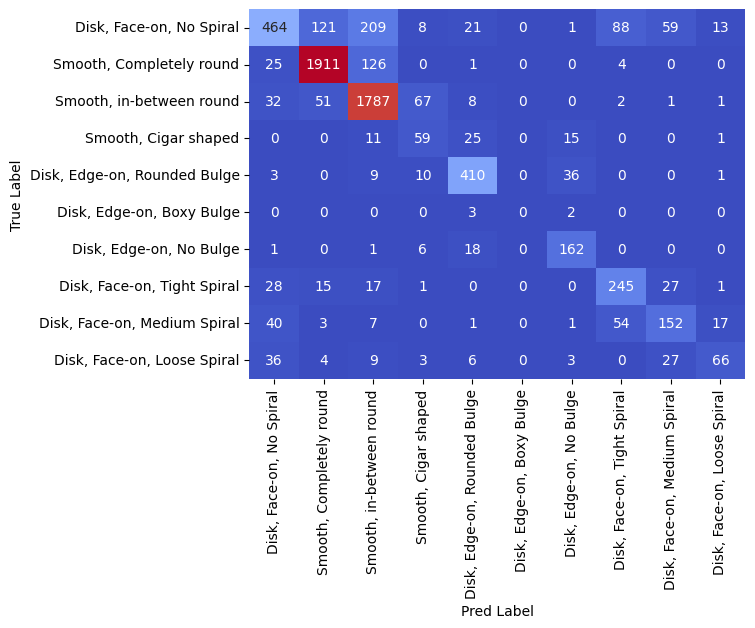

In [12]:
labels = []

for i in range(10):
    labels.append(galaxy10cls_lookup(i))


cm = confusion_matrix(y_pred=predicted_labels, y_true=true_labels)

sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=labels, yticklabels=labels)
plt.ylabel('True Label')
plt.xlabel('Pred Label')
plt.show()